In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math
import pickle
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, log_loss

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression


import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# !pip install imbalanced-learn
# !pip install xgboost

In [2]:
def memory(df):
    print("Memory usage of the dataframe is {:.2f} MB".format(
        df.memory_usage().sum() / 1024**2))
    
    
def entropy(df, base = 2):
    """ Calculate the entropy for every column in a df"""
    
    entropy = {}
    
    for column in df.columns:
        prob = df[column].value_counts(normalize=True, sort=False)
        
        entropy[column] = -(prob * np.log(prob)/np.log(base)).sum()
        
    return pd.Series(entropy).sort_values(ascending=False)

In [3]:
google_drive = False
convert = False

if(google_drive):
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/we_data/train.csv')
    
elif(convert):
    train = pd.read_csv('../we_data/train.csv')
    train.to_hdf('train.h5', 'train')
    
else:
#     train = pd.read_hdf('../train.h5', 'train')
    train = pd.read_csv('../we_data/train.csv')
    validation = pd.read_csv('../we_data/validation.csv')
    test = pd.read_csv('../we_data/test.csv')

In [4]:
train.isnull().sum()

click                   0
weekday                 0
hour                    0
bidid                   0
userid                  0
useragent               0
IP                      0
region                  0
city                    0
adexchange          49829
domain             137135
url                 86812
urlid             2430981
slotid                  0
slotwidth               0
slotheight              0
slotvisibility          0
slotformat              0
slotprice               0
creative                0
bidprice                0
payprice                0
keypage            504990
advertiser              0
usertag            497479
dtype: int64

In [5]:
train['adexchange'].value_counts()

3.0    819458
2.0    763428
1.0    718271
4.0     79995
Name: adexchange, dtype: int64

In [6]:
entropy(train)

bidid             21.213107
userid            21.136952
IP                18.103315
url               16.149660
usertag           14.872094
slotid             9.422239
domain             8.498091
city               7.422192
payprice           7.076786
creative           5.873560
region             4.533946
hour               4.382678
slotprice          3.269283
keypage            3.195136
slotwidth          3.064538
advertiser         2.930429
weekday            2.799784
bidprice           2.614787
slotvisibility     2.351020
slotheight         2.024556
adexchange         1.741802
slotformat         1.478337
useragent          1.447568
click              0.008738
urlid             -0.000000
dtype: float64

In [8]:
train.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,22,b7bea80521fdecd95d2d761a38c91c3f09618066,2e880fb7d690cf7377b2e42e701728e3f3c0e4c1,windows_ie,125.37.175.*,2,2,2.0,trqRTvKaXTKfgg24JKTI,6447a7dfa30fe6eb410c91860e7c9b45,NaN,2015392487,200,200,2,0,5,a4f763f78ef3eedfe614263b94a8924e,238,5,0f951a030abdaedd733ee8d114ce2944,3427,NaN
1,0,1,20,4f51205475678f5a124bc76b2c54163bf8eaa7eb,3a1fe01360ff8100e7d006b83b77a3e4c01d928c,windows_chrome,171.36.92.*,238,239,1.0,20fc675468712705dbf5d3eda94126da,3ddf173a94bd23c326683b6373c75dd4,NaN,mm_10982364_973726_8930541,300,250,FourthView,Na,0,10722,294,23,NaN,2821,NaN
2,0,3,13,b604e3fd054a658ab7ced4285ebf2ef54d2bd890,801d18a056b6fe6b06a794aef17fb0d6daff2414,windows_ie,59.46.106.*,40,41,2.0,trqRTJn7O95I1mKYUV,625d1b5916ea925332c7b326c0574cfa,NaN,1720123646,250,250,2,0,5,798b2d49952d77f1eace9f23c210d0b5,238,24,0f951a030abdaedd733ee8d114ce2944,3427,"10052,10006,13866,10110"
3,0,6,23,0348beeae93e561584c3b50fc9e7746a33048ad7,0d6eaf2259699990e38a1fc5116f112070b9ecdc,windows_ie,114.250.226.*,1,1,1.0,5F97t5E0BTK7XhNrUMpENpn,dedc488b98ca20707bc9a723957e7d1f,NaN,mm_10027070_118039_10308280,160,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,25,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10063,10111"
4,0,5,6,268149c1789bce2bc9798ffd97ec431219bafeb3,a239d9bb642460d974ba67f85e63b8d3e214da0e,windows_ie,183.63.192.*,216,233,2.0,13625cb070ffb306b425cd803c4b7ab4,4199d1227c511fc776b76594dabff9f8,NaN,1120200150,728,90,OtherView,Na,133,7330,277,133,NaN,2259,NaN


In [7]:
no_click,click = train['click'].value_counts().values
print('Baseline average CTR {:.5%}'.format(click/(no_click+no_click)))

Baseline average CTR 0.03691%


## Feature engineering

In [8]:
def count_featuresize_one_hot_encoding(df):
    """Calcualte the number of featuers nessecary for one hot encoding"""

    total_features = 0
    for column in df.columns:
        total_features += len(df[column].unique())

    print('Rougly {:,} features in the feature space'.format(total_features))

    return total_features


def feature_engineering(df):
    """ Enrich dataframe with additional features
    
        Note that all fields that are joined are slightly redundent when
        implementing more sophisticated models like NN that could pick up
        on these feature combinations, however, it can improve the perforamce
        of simpler models such as logisitc regression"""

    # split user agent into os and browser
    df['os'], df['browser'] = df['useragent'].str.split('_').str

    # apple users
    df['apple'] = df['useragent'].str.match(r'(ios)|(mac)').astype(np.uint8)

    # deterime mobile devivce or not
    df['mobieldevice'] = df['useragent'].str.match(r'(ios)|(android)').astype(
        np.uint8)

    # hour per day
    df['weekdayhour'] = df['weekday'].astype(str) + '_' + df['hour'].astype(
        str)

    # bin hours into time of day
    df['timeofday'] = pd.cut(
        df['hour'].astype(int),
        4,
        labels=["night", "morning", "afternoon", "evening"])

    # bin ad surface size categories
    min_ad = min(df['slotwidth'] * df['slotheight']) - 1
    max_ad = max(df['slotwidth'] * df['slotheight'])

    ad_bins = pd.IntervalIndex.from_breaks(
        [min_ad, 65520, 75000, 90000, max_ad])

    replace, with_ = [
        pd.Interval(min_ad, 65520),
        pd.Interval(65520, 75000),
        pd.Interval(75000, 90000),
        pd.Interval(90000, max_ad)
    ], ['small', 'medium', 'large', 'x-large']

    df['adsize'] = pd.cut(
        df['slotwidth'] * df['slotheight'], bins=ad_bins).replace(
            replace, with_)

    # bin slot price into categories
    price_bins = pd.IntervalIndex.from_breaks(
        [min(df['slotprice']), 10, 50, 100,
         max(df['slotprice'])],
        closed='left')
    replace, with_ = [
        pd.Interval(min(df['slotprice']), 10, closed='left'),
        pd.Interval(10, 50, closed='left'),
        pd.Interval(50, 100, closed='left'),
        pd.Interval(100, max(df['slotprice']), closed='left')
    ], ['1', '2', '3', '4']

    df['slotprice'] = pd.cut(
        df['slotprice'], bins=price_bins).replace(replace, with_)

    # ad size category and visability
    df['advisabilitysize'] = df['slotvisibility'].astype(
        str) + '_' + df['adsize'].astype(str)

    return df.drop(columns=['slotwidth', 'slotheight'])


def pre_process_one_hot_encoding(df):
    """ Preprocess the dataframe for one hot encoding
    
        - Split the filed user tags and binary encode
        - Convert numerical categories into strings 
        """

    # convert numerical categories into strings as a quick hack
    # for one hot encoding to work properly on numerical categories
    df['weekday'] = df['weekday'].astype(str)
    df['hour'] = df['hour'].astype(str)
    df['region'] = df['region'].astype(str)
    df['city'] = df['city'].astype(str)
    df['adexchange'] = df['adexchange'].astype(str)
    df['advertiser'] = df['advertiser'].astype(str)

    # already processed and not found in columns
    if ('usertag' not in df.columns):
        return df

    df['usertag'] = df['usertag'].astype(str)
    mlb = MultiLabelBinarizer()

    df = df.join(
        pd.DataFrame(
            mlb.fit_transform(df['usertag'].str.split(',')),
            columns='usertag_' + mlb.classes_,
            index=df.index))

    # drop the usertag column
    df = df.drop(columns='usertag')

    return df


def drop_colums(df):

    # Remove uniuqe and meaningless featuers that are not know a pirori
    columns = ['bidprice', 'urlid', 'bidid']

    # remove some very sparse fields to reduce featuers (highest entropy)
    columns.extend(['userid', 'url', 'domain', 'slotid', 'IP'])

    # only remove columns that are in the df
    columns = [column for column in columns if column in df.columns]

    return df.drop(columns=columns)


def add_missing_colums(df, columns, sort_columns=True):
    """ Due to the feature engineering there is a chance a discrapency occurs
        between 
        """

    missing = [x for x in columns if x not in df.columns]

    for x in missing:
        print('Adding {}'.format(x))
        df[x] = 0

    if (sort_columns):
        return df[sorted(df.columns)]

    return df

## Performance metrics

In [5]:
def calcluate_num_impressions(df, grouping = False):
    imp = {}
    
    if(grouping):
        imp = df.groupby(grouping).size().to_dict()
            
    else:
        imp = len(df)
    
    print(imp)
    return imp
    


def calcluate_num_clicks(df, grouping = False):
    clicks = {}
    
    if(grouping):
        for index, group in df.groupby(grouping):
            clicks[index] = np.sum(group['click'])
            
    else:
        clicks = np.sum(df['click'])
    
    print(clicks)
    return clicks
    

def calcluate_ctr(df, grouping = False):
    ctr = {}
    
    if(grouping):
        for index, group in df.groupby(grouping):
            ctr[index] = np.average(group['click']) * 100
            
    else:
        ctr = np.average(df['click']) * 100
    
    print(ctr)
    return ctr
    
    
def average_cost_per_mille(df, grouping = False):
    cpm = {}
    
    if(grouping):
        cpm = df.groupby('weekday').agg({'payprice': np.mean}).to_dict()['payprice']
        
    else:
        cpm = np.mean(df['payprice'])
        
    print(cpm)
    return cpm

In [12]:
train.shape, validation.shape, test.shape

((2430981, 25), (303925, 25), (303375, 22))

## Build feature matrix

In [9]:
"""
other fillna strategies for adexchange should be considered at some point!

the only columns that contain a lot of missing values that are used in the final 
analysis are adexchange and usertag. Different strategies have been considered but 
it was deemed to be the most informative to assign a 'unknown' class which is easely
achieved trhough filling 0's since they do not occur in the dataset

"""

%time train = drop_colums(train)
%time train = train.fillna(0)
%time train = feature_engineering(train)
%time train = pre_process_one_hot_encoding(train)
%time train = pd.get_dummies(train)

memory(train)
print('done')

CPU times: user 326 ms, sys: 211 ms, total: 537 ms
Wall time: 541 ms
CPU times: user 926 ms, sys: 328 ms, total: 1.25 s
Wall time: 1.26 s
CPU times: user 1min 9s, sys: 2 s, total: 1min 11s
Wall time: 1min 12s
CPU times: user 26.3 s, sys: 13.2 s, total: 39.5 s
Wall time: 42.3 s
CPU times: user 25.9 s, sys: 13.1 s, total: 39 s
Wall time: 42.6 s
Memory usage of the dataframe is 3389.45 MB
done


In [10]:
%time test = drop_colums(test)
%time test = test.fillna(0)
%time test = pre_process_one_hot_encoding(test)
%time test = feature_engineering(test)
%time test = pd.get_dummies(test)
print('done')

CPU times: user 103 ms, sys: 298 ms, total: 401 ms
Wall time: 538 ms
CPU times: user 121 ms, sys: 71.1 ms, total: 192 ms
Wall time: 198 ms
CPU times: user 3.41 s, sys: 2.28 s, total: 5.69 s
Wall time: 6.32 s
CPU times: user 8.47 s, sys: 215 ms, total: 8.68 s
Wall time: 8.73 s
CPU times: user 2.71 s, sys: 443 ms, total: 3.15 s
Wall time: 3.17 s
done


In [11]:
%time validation = drop_colums(validation)
%time validation = validation.fillna(0)
%time validation = feature_engineering(validation)
%time validation = pre_process_one_hot_encoding(validation)
%time validation = pd.get_dummies(validation)
print('done')

CPU times: user 89.9 ms, sys: 284 ms, total: 374 ms
Wall time: 501 ms
CPU times: user 121 ms, sys: 72.9 ms, total: 194 ms
Wall time: 196 ms
CPU times: user 12.1 s, sys: 523 ms, total: 12.6 s
Wall time: 14.3 s
CPU times: user 3.39 s, sys: 580 ms, total: 3.97 s
Wall time: 4.06 s
CPU times: user 2.53 s, sys: 458 ms, total: 2.99 s
Wall time: 3.31 s
done


In [12]:
# the featuere engineering can construct columns that do not occur in other sets 
# this adds the columns of the joined colomuns
joined_colums = [item for slist in [validation.columns, train.columns, test.columns] for item in slist]

%time train = add_missing_colums(train,joined_colums)
%time validation = add_missing_colums(validation,joined_colums)
%time test = add_missing_colums(test,joined_colums)
print('done')

CPU times: user 8.41 s, sys: 16.9 s, total: 25.3 s
Wall time: 29.9 s
Adding useragent_android_ie
Adding useragent_android_maxthon
Adding useragent_other_firefox
Adding creative_7324
Adding creative_7332
Adding useragent_android_maxthon
Adding creative_7332
CPU times: user 977 ms, sys: 1.57 s, total: 2.55 s
Wall time: 2.78 s
Adding click
Adding payprice
Adding useragent_linux_ie
Adding useragent_mac_maxthon
Adding useragent_mac_sogou
Adding creative_7327
Adding click
Adding payprice
Adding useragent_android_ie
Adding useragent_linux_ie
Adding useragent_mac_maxthon
Adding useragent_mac_sogou
Adding useragent_other_firefox
Adding creative_7324
Adding creative_7327
CPU times: user 1.03 s, sys: 1.47 s, total: 2.49 s
Wall time: 2.83 s
done


In [ ]:
# this list should be empty!!
[x for x in validation.columns if x not in train.columns]

In [13]:
train.to_hdf('preprocessed.h5', 'train')
validation.to_hdf('preprocessed.h5', 'validation')
test.to_hdf('preprocessed.h5', 'test')
print('done')

done


### OPTION 1: Apply bloom filter on all filters

In [ ]:
# test_dict = df_copy.drop(columns='click').T.to_dict().values()
# h = FeatureHasher(n_features=20000)
# maxtix = h.transform(test_dict)

In [529]:
# maxtix.toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

### OPTION 2: Get feature matrix of select number of features

## Balance dataset

There is a significant unbalance between the click and the non-click class. In an attempt to increase numerical stability of the training models the majority class will be under sampled (observations will be removed) and the minority class will be oversampled generating new samples. Considering a sample x_i, a new sample x_{new} will be generated considering its k neareast-neighbors. 

SMOTEENN Combines over and under sampling

In [8]:
%%time
# train = pd.read_hdf('preprocessed.h5', 'train')
validation = pd.read_hdf('preprocessed.h5', 'validation')
# test = pd.read_hdf('preprocessed.h5', 'test')
print('done')

done
CPU times: user 239 ms, sys: 731 ms, total: 970 ms
Wall time: 2.35 s


In [5]:
%%time
pre_subsample_size = int(1e5)
final_resample_ratio = 1/10

np.random.seed(9345)

print('Original:')
print(train['click'].value_counts())
print('')

# random sample from the non click class, pre subsameling will improve speed
# since SMOTETomek does not take an output number samples as parameter
class0_index = train[train['click'] == 0].index

# take random sample
%time random_subsample = np.random.choice(class0_index, pre_subsample_size, replace=False)
class0_downsampled = train.loc[random_subsample]
class1 = train[train['click'] == 1]

# combine dataframes
training_data = pd.concat([class0_downsampled,class1])

# free memory
del(class0_index, class0_downsampled, class1)

print('Random subsample class0:')
print(training_data['click'].value_counts())
print('')

# use all but one avalible processors
smote = SMOTE(k_neighbors=3, n_jobs=-1)
tomek = TomekLinks(n_jobs=-1)

smote_omek = SMOTETomek(ratio=final_resample_ratio, smote=smote, tomek=tomek)

y = training_data['click'].values
X = training_data.drop(columns=['click', 'payprice'])

%time X_resampled, y_resampled = smote_omek.fit_resample(X, y,)

# free memory
# del(y, X)

print('Final balance:')
sample, count = np.unique(y_resampled, return_counts=True)
print(pd.Series(dict(np.array((sample,count)).T)))

print('\nBaseline accuracy: {:.3%}'.format(count[0]/len(y_resampled)))

# export resample
pickle.dump((X_resampled, y_resampled), open("resampled", "wb" ))

print('\ndone\n')

Original:
0    2429188
1       1793
Name: click, dtype: int64

CPU times: user 133 ms, sys: 39.7 ms, total: 173 ms
Wall time: 192 ms
Random subsample class0:
0    100000
1      1793
Name: click, dtype: int64

CPU times: user 7h 45min 54s, sys: 4min 5s, total: 7h 49min 59s
Wall time: 3h 13min 7s
Final balance:
0    100000
1     99793
dtype: int64

Baseline accuracy: 50.052%

done

CPU times: user 7h 46min 3s, sys: 4min 27s, total: 7h 50min 31s
Wall time: 3h 13min 50s


## Train LR model

Download pickle resampled data from:
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/resampled?csf=1&e=swcNPL
*It contains a exsension less file, you might need to remove it if you find troubles using it*

contains tuple(X_resampled, y_resampled)


*alternatively download the trained LR model here:*
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/lr_model?csf=1&e=5j4WJX

In [230]:
max_payprice = max(validation[validation['click'] == 1]['payprice'])

def sampele_weight(x, max_payprice):
    return np.round(1.5 + np.log(max_payprice/x)/2, 1)

sample_weights = validation['click'].where(validation['click'] == 1, 1).where(
    validation['click'] == 0,
    sampele_weight(validation['payprice'], max_payprice)).replace(np.inf,1).values

In [53]:
%%time
random_seed = 4448
# load resampled date
# X_resampled, y_resampled = pickle.load(open( "resampled", "rb" ))

lr = LogisticRegression(solver='lbfgs', max_iter=500, C=1, n_jobs=-1, random_state=1, class_weight='balanced') 

lr.fit(X_resampled, y_resampled)

# export model
pickle.dump(lr, open( "lr_model", "wb" ))

print('done')

done
CPU times: user 1.97 s, sys: 4.68 s, total: 6.65 s
Wall time: 2min 30s


### Evaluate LR model testset from train

In [206]:
lr = pickle.load(open( "lr_model", "rb" ))

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1)
# %time lr.fit(X_train, y_train)

# performance
y_hat = lr.predict(X_test)

print(classification_report_imbalanced(y_test, y_hat, target_names=['no click', 'click']))
print("Balanced accuracy score: {:.3%}".format(balanced_accuracy_score(y_test, y_hat) ))
print('ROC AUC score {}'.format(roc_auc_score(y_test, y_hat)))
print('done')

                   pre       rec       spe        f1       geo       iba       sup

   no click       0.95      0.96      0.95      0.96      0.96      0.91     25071
      click       0.96      0.95      0.96      0.96      0.96      0.91     24891

avg / total       0.96      0.96      0.96      0.96      0.96      0.91     49962

Balanced accuracy score: 95.566%
ROC AUC score 0.9556594981954275
done


## Evaluate LR model on validation

In [9]:
y_validate_true = validation['click'].values
X_validate = validation.drop(columns=['click', 'payprice'])

In [59]:
# y_validate_class = lr.predict(X_validate)
print(classification_report_imbalanced(y_validate_true, y_validate_class, target_names=['no click', 'click']))
print('ROC AUC score {:.5f}'.format(roc_auc_score(y_validate_true, y_validate_class)))
print("Balanced accuracy score: {:.5f}".format(balanced_accuracy_score(y_validate_true, y_validate_class)))
print('done')

                   pre       rec       spe        f1       geo       iba       sup

   no click       1.00      1.00      0.17      1.00      0.42      0.19    303723
      click       0.04      0.17      1.00      0.06      0.42      0.16       202

avg / total       1.00      1.00      0.17      1.00      0.42      0.19    303925

ROC AUC score 0.58508
Balanced accuracy score: 0.58508
done


### Optimize log loss

In [21]:
for c in [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]:
 
    lr = LogisticRegression(solver='lbfgs', max_iter=500, C=c, n_jobs=-1) 
    lr.fit(X_train, y_train)
    
    y_validate_prob = lr.predict_proba(X_validate)
    print('For C {} Log loss {}'.format(c, log_loss(y_validate_true, y_validate_prob)))
    print('For C {} ROC AUC {}'.format(c, roc_auc_score(y_validate_true, y_validate_prob[:,1])))

For C 1e-05 Log loss 0.6283247722343959
For C 1e-05 ROC AUC 0.677960593196843
For C 0.0001 Log loss 0.47451734312946786
For C 0.0001 ROC AUC 0.7382511171673067
For C 0.001 Log loss 0.2593739151498666
For C 0.001 ROC AUC 0.7823443817994269
For C 0.01 Log loss 0.13113844024481888
For C 0.01 ROC AUC 0.7858815254506754
For C 0.1 Log loss 0.0740039391460614
For C 0.1 ROC AUC 0.7747698992793166
For C 1 Log loss 0.08815361277923775
For C 1 ROC AUC 0.7718528164488597


## Linear bidding strategy pCTR

In [20]:
%%time
y_validate_prob = lr.predict_proba(X_validate)

payprice = validation['payprice']
clicks = validation['click']

# VERIFY THAT THE pCTR INDEED IS EQUAL TO THE PROB OF CLICK == 1
pCTR = y_validate_prob[:, 1]

no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)

bid_strategy = lambda base_bid: base_bid * (pCTR / avgCTR)

bid_range = np.arange(3.4, 3.8, 0.02)
bid_range_wide = np.arange(1, 5, .5)
bid_range = np.concatenate((bid_range, bid_range_wide), axis=0)

# bid_range = np.arange(1.7, 1.9, 0.01)
statistics = {}

# find optimal base_bid
for base_bid in tqdm(bid_range):
    
    budget_remaining = 6250*1000
    
    statistics[base_bid] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0
    }
    
    # list of bids for all ad requests
    bids = bid_strategy(base_bid)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(won):
            statistics[base_bid]['impressions'] += 1
            statistics[base_bid]['spend'] += second_highest_bid
            statistics[base_bid]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

100%|██████████| 28/28 [02:22<00:00,  4.86s/it]

done
CPU times: user 2min 26s, sys: 8.33 s, total: 2min 35s
Wall time: 2min 39s


In [55]:
statistics.sort_values('clicks', ascending=False).head(5)

,clicks,impressions,spend,CTR,aCPM,aCPC
3.52,149,115531,6186524,0.001290,53.548606,41.520295
3.54,149,115967,6216512,0.001285,53.605871,41.721557
3.56,149,116375,6242966,0.001280,53.645250,41.899101
3.60,149,116315,6250000,0.001281,53.733396,41.946309
3.46,148,114269,6101602,0.001295,53.396827,41.227041


In [69]:
lr

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

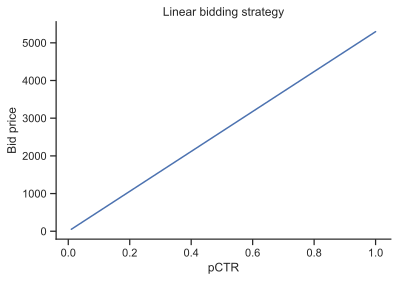

In [18]:
x = np.linspace(1e-2, 1)
no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)
y = 3.52 * (x / avgCTR)

plt.plot(x,y)
sns.despine()
plt.title('Linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.show()

### Apply linear strategy pCTR to test set

In [28]:
%%time
X_test = test.drop(columns=['click', 'payprice'])
y_test_prob = lr.predict_proba(X_test)
avgCTR = click / (no_click + click)

base_bid = 3.52
pCTR = y_test_prob[:, 1]

bid_strategy = lambda base_bid: (base_bid * (pCTR / avgCTR))

CPU times: user 8.48 s, sys: 8.23 s, total: 16.7 s
Wall time: 19.1 s


In [29]:
# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

In [37]:
# export to file
df_bids = pd.DataFrame(np.round(bid_strategy(base_bid),1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

In [38]:
df_bids.to_csv('bid_attemnt.csv', index=False)

## ORTB bidding

In [22]:
%%time
payprice = validation['payprice']
clicks = validation['click']

no_click, click = np.bincount(clicks)
avgCTR = click / (no_click + click)

ortb_strategy = lambda lamda, const, pCTR: np.sqrt(np.multiply((const / lamda), pCTR) + const**2) - const

lamda_range = np.linspace(1e-7, 1e-4, num=20)
const_range = np.arange(10, 100, 10)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

# find optimal base_bid
for const, lamda in tqdm(parameter_grid):
    budget_remaining = 6250*1000
    
    index = (const, lamda)
    
    statistics[index] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0
    }
    
    # list of bids for all ad requests
    bids = ortb_strategy(lamda, const, pCTR)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[index]['too_expensive'] += 1
        
        
        if(won):
            statistics[index]['impressions'] += 1
            statistics[index]['spend'] += second_highest_bid
            statistics[index]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

100%|██████████| 180/180 [15:56<00:00,  4.97s/it]

done
CPU times: user 15min 13s, sys: 6.81 s, total: 15min 20s
Wall time: 15min 56s


In [23]:
statistics.sort_values('clicks', ascending=False).head(5)

,,clicks,impressions,spend,too_expensive,CTR,aCPM,aCPC
60,0.000053,149,126355,6249999,2084,0.001179,49.463804,41.946302
20,0.000032,149,128585,5999568,0,0.001159,46.658382,40.265557
70,0.000058,149,124008,6140701,0,0.001202,49.518588,41.212758
50,0.000053,148,123045,5957982,0,0.001203,48.421163,40.256635
90,0.000063,148,122761,6141601,0,0.001206,50.028926,41.497304


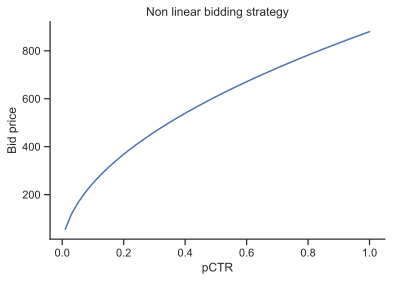

In [30]:
x = np.linspace(1e-2, 1)
no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)
y = ortb_strategy(0.000058,50,x)

plt.plot(x,y)
sns.despine()
plt.title('Non linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.show()